# Recycle systems

## Example

![BuOH_separation](../images/BuOH_separation.png)

Recycle systems in BioSTEAM are solved through accelerated fixed-point iteration (just like in Aspen Plus and SuperPro). Let's create an industry-relevant system for the purification of butanol from fermentation broth in 2 steps:

1. Create and solve the network of unit operations. 

2. Visualize the recycle system.


**Step 1: Build the system**

In [5]:
import biosteam as bst
bst.nbtutorial()
bst.settings.set_thermo(['Water', 'Butanol'], cache=True)
with bst.System() as sys:
    feed = bst.Stream(
        'feed', 
        phase='l', 
        Water=900,
        Butanol=100,
        units='kmol/hr',
    )
    water_rich = bst.Stream('water_rich')
    distillate_1 = bst.Stream('distillate_1')
    
    # Dewater
    water_distiller = bst.BinaryDistillation(
        ins=(feed, water_rich), outs=('distillate_0', 'water'),
        x_bot=0.0001, y_top=0.2, k=1.2, Rmin=0.01,
        LHK=('Butanol', 'Water'),
        partial_condenser=False,
    )
    distillate_0 = water_distiller.outs[0]
    distillate_1 = bst.Stream('distillate_1')
    
    # Decanter
    mixer = bst.Mixer('mixer', ins=(distillate_0, distillate_1))
    hx = bst.HXutility('heat_exchanger', ins=mixer-0, T=310, V=0)
    settler = bst.MixerSettler(
        'settler',
        ins=hx-0, 
        outs=('butanol_rich', water_rich),
        top_chemical='Butanol',
    )
    
    # Butanol purification
    butanol_distiller = bst.BinaryDistillation(
        ins=settler-0,
        outs=(distillate_1, 'butanol'),
        x_bot=0.0001, y_top=0.6, 
        k=1.2, Rmin=0.01,
        LHK=('Water', 'Butanol'),
        partial_condenser=False,
    )
sys.simulate()
sys.show()

System: SYS1
Highest convergence error among components in recycle
streams {D2-0, settler-1} after 5 loops:
- flow rate   9.03e-01 kmol/hr (0.2%)
- temperature 0.00e+00 K (0%)
ins...
[0] feed  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water    900
                    Butanol  100
outs...
[0] water  
    phase: 'l', T: 373.07 K, P: 101325 Pa
    flow (kmol/hr): Water    901
                    Butanol  0.0901
[1] butanol  
    phase: 'l', T: 390.84 K, P: 101325 Pa
    flow (kmol/hr): Water    0.01
                    Butanol  100


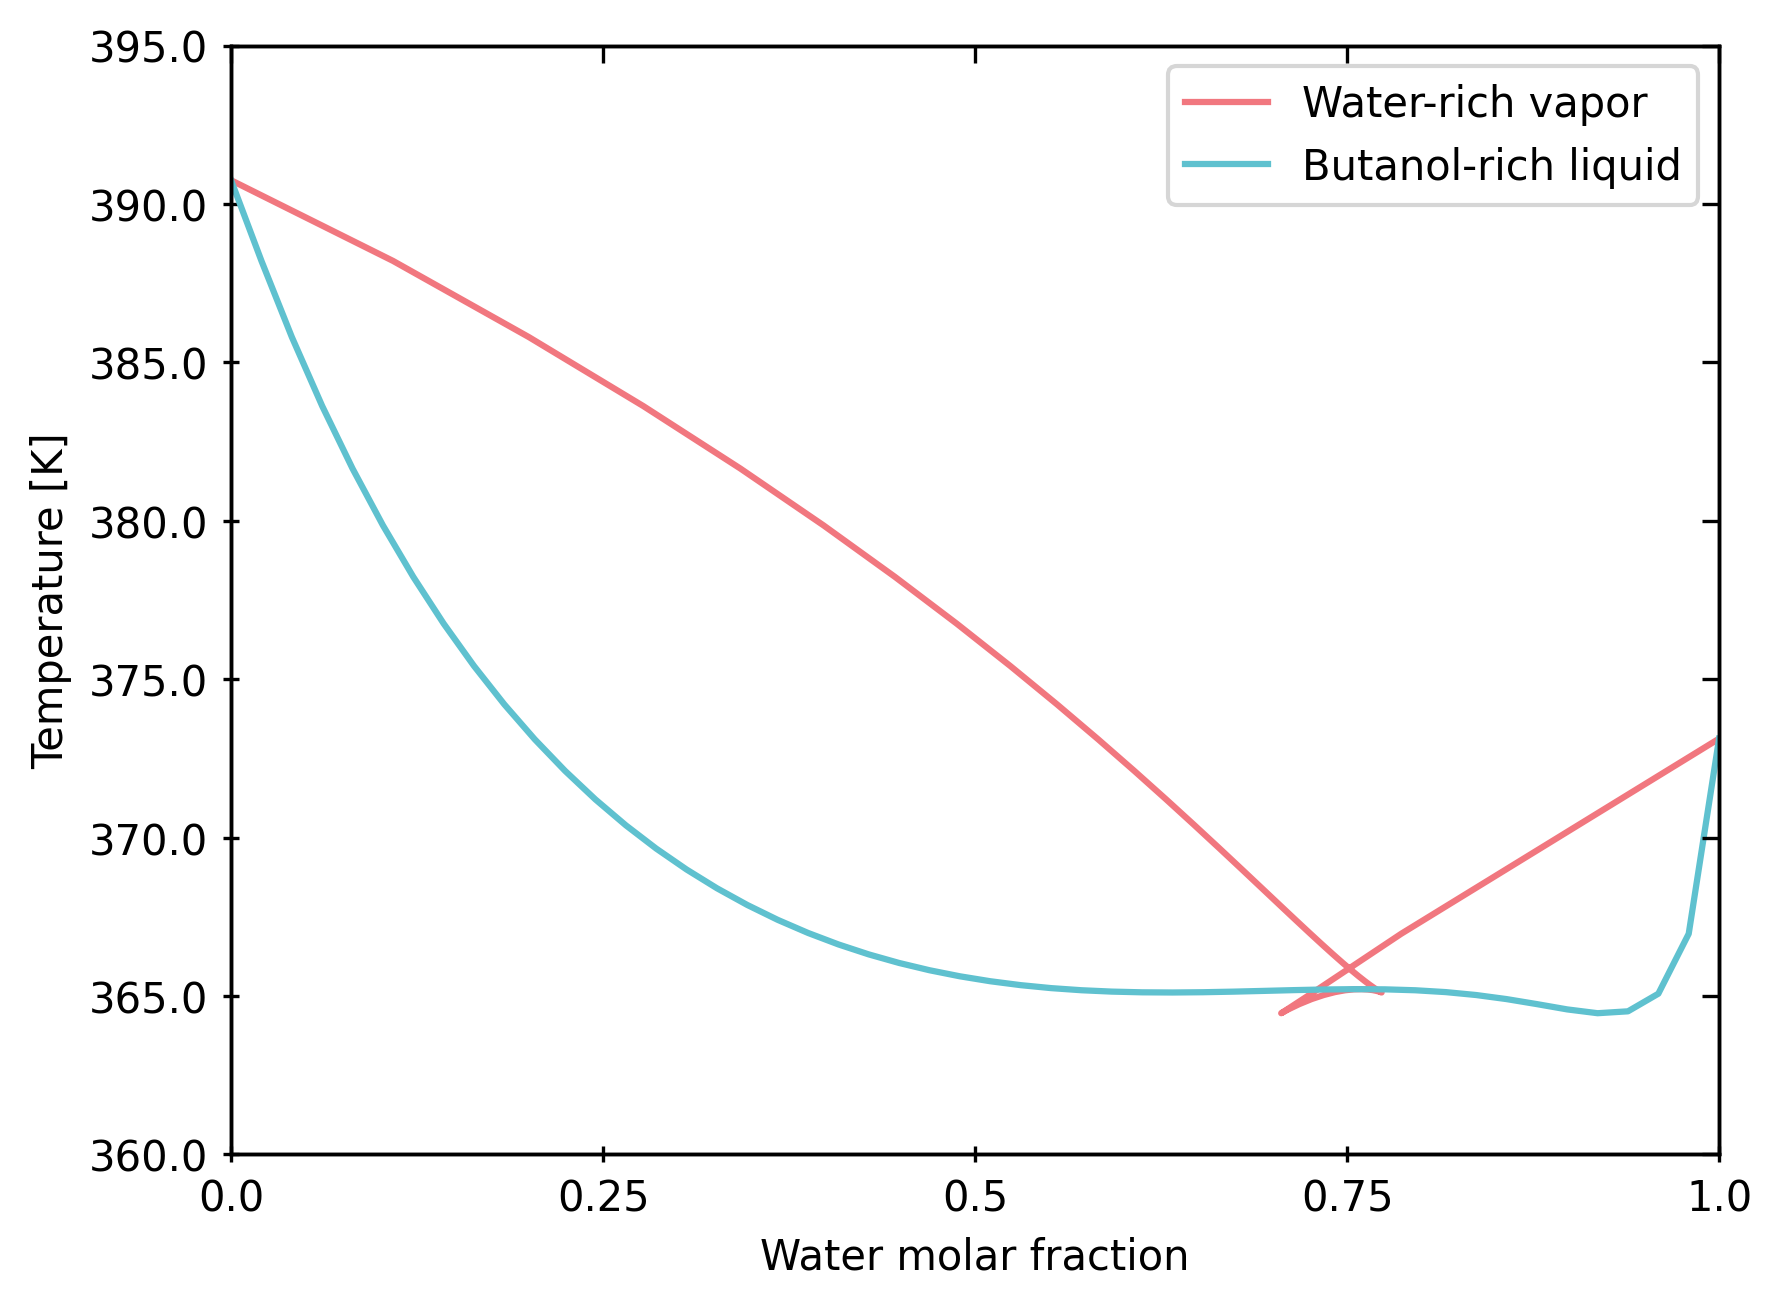

In [6]:
bst.plot_vle_binary_phase_envelope(['Water', 'Butanol'], P=101325)

**Step 2: Visualize the system**

Pass `number=True` to label the simulation order in the diagram:

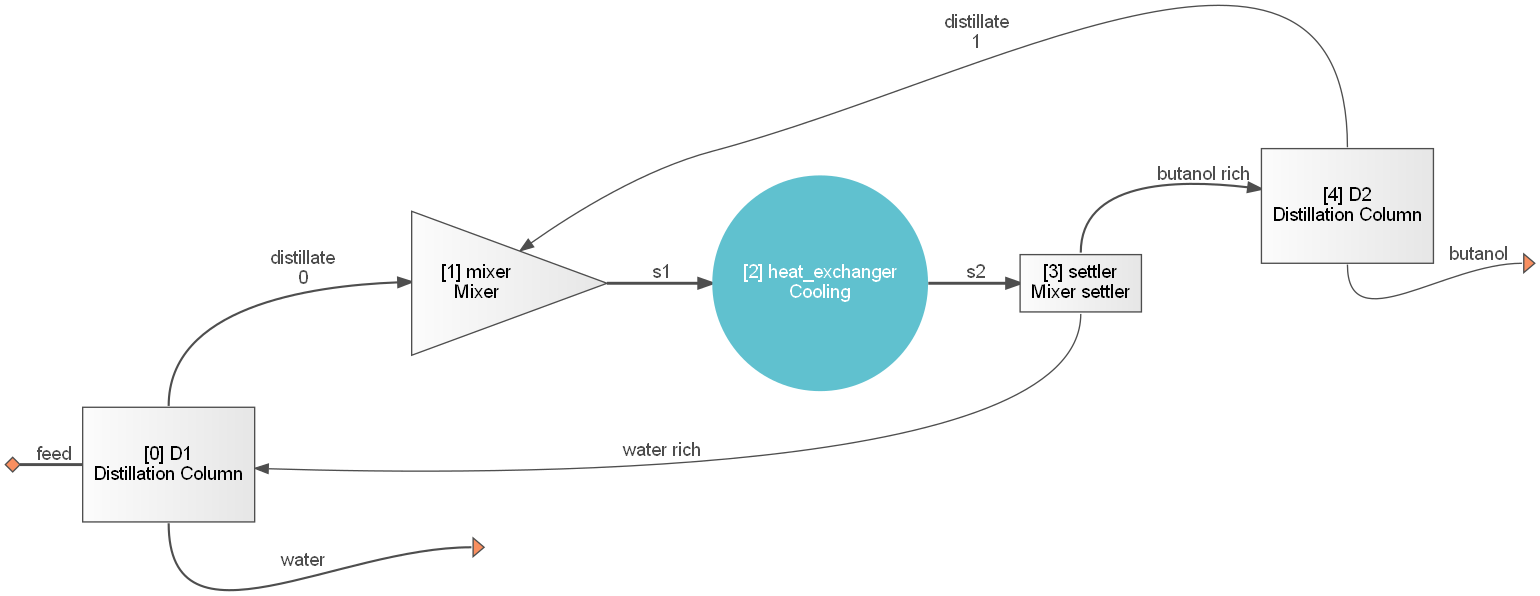

In [7]:
sys.diagram(number=True, format='png')

This topography shows a flat system without explicit recycle loops. To view the nested system, pass `kind='cluster'`:

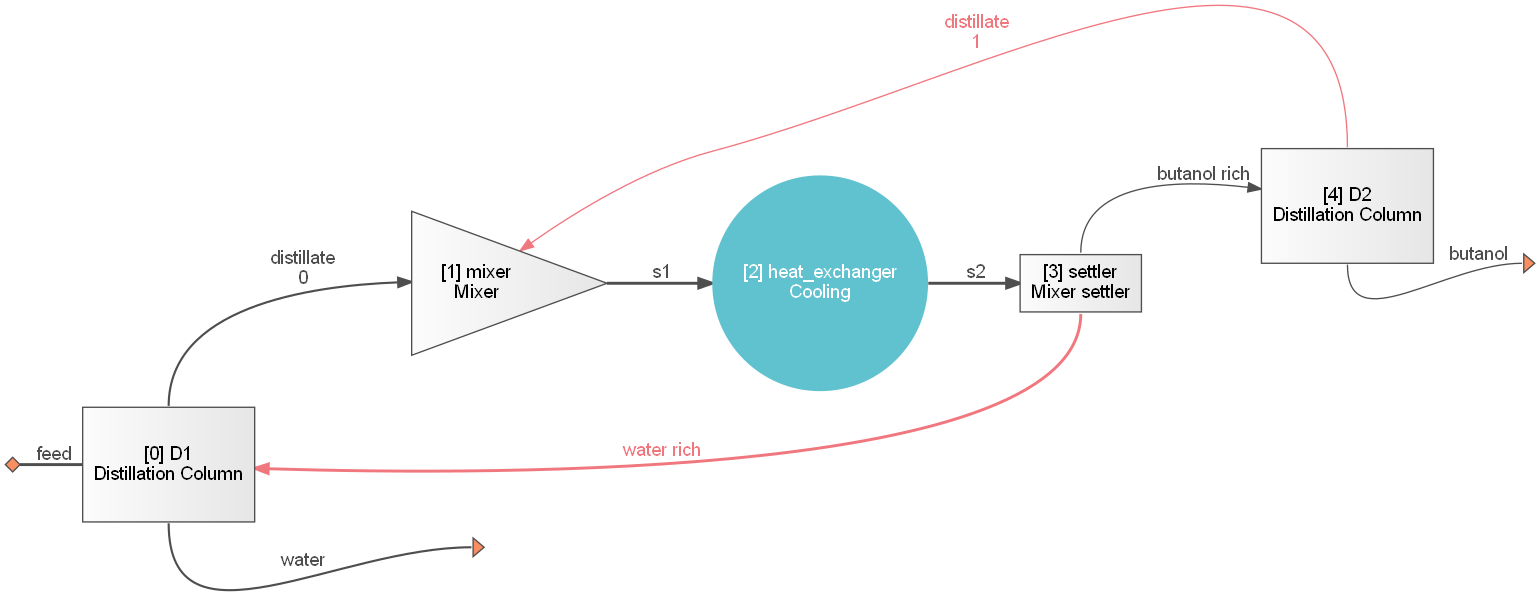

In [8]:
sys.diagram(number=True, kind='cluster', format='png')

Some unit operations are composed of multiple unit operations that are solved internally with specialized algorithms. To view the first layer of these auxiliary units, pass `auxiliaries=1`:

## Problem

As an excericise, let's look model a common configuration for distillation with heat integration. We will create and analyse a beer column with heat integration for the separation of ethanol from fermentation broth. Connect all the units together to match the following flowsheet:

![distillation_heat_integration](../images/distillation_heat_integration.png)

**Instructions:** Replace all `None`s with the correct values.

In [2]:
import biosteam as bst
bst.nbtutorial()
bst.settings.set_thermo(['Water', 'Ethanol'])
with bst.System() as sys:
    dilute_ethanol = bst.Stream(
        'dilute_ethanol',
        Ethanol=12,
        Water=88,
        total_flow=1.5e5,
        units='kg/hr',
    )
    pump = bst.Pump(ins=None, outs='cold_feed', P=6 * 101325)
    hot_bottoms_product = bst.Stream('hot_bottoms_product')
    heat_exchanger = bst.HXprocess(
        ins=(None, None), # Hint: cold_feed, hot_bottoms_product
        outs=('hot_feed', 'cooled_bottoms_product'),
    )
    beer_column = bst.BinaryDistillation(# ShortcutColumn for 3+ components
        ins=None,
        outs=('distillate', 'bottoms_product'), 
        LHK=('Ethanol', 'Water'), # Light and heavy key
        P=2.1 * 101325, # Operating pressure [Pa]
        y_top=0.35, # Distillate light-key fraction
        x_bot=1e-5, # Bottoms heavy-key fraction
        k=1.1, # Actual reflux over minimum reflux ratio
    )
    pump = bst.Pump(
        ins=None, 
        outs=recycle, # Outlet goes to heat exchanger
        P=4 * 101325
    )
sys.simulate()
sys.show()

System: SYS1
Highest convergence error among components in recycle
stream P2-0 after 2 loops:
- flow rate   0.00e+00 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
ins...
[0] dilute_ethanol  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water    7.33e+03
                    Ethanol  391
outs...
[0] distillate  
    phase: 'g', T: 383.54 K, P: 212782 Pa
    flow (kmol/hr): Water    726
                    Ethanol  391
[1] cooled_bottoms_product  
    phase: 'l', T: 303.15 K, P: 405300 Pa
    flow (kmol/hr): Water    6.6e+03
                    Ethanol  0.066


In [3]:
sys.diagram(number=True, kind='cluster', format='svg')